In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['sample_submission.csv', 'plates.zip']
After zip extraction:
['submission.csv', 'train', 'val', 'plates', '__notebook_source__.ipynb', '__MACOSX']


In [2]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['train', '.DS_Store', 'test']


In [3]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 3563.41it/s]


In [4]:
!ls train

cleaned  dirty


In [5]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [6]:
len(train_dataloader), len(train_dataset)

(5, 34)

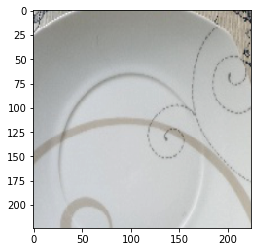

In [7]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

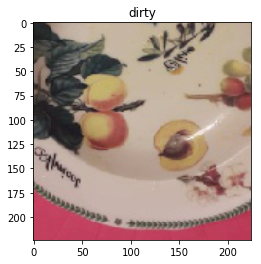

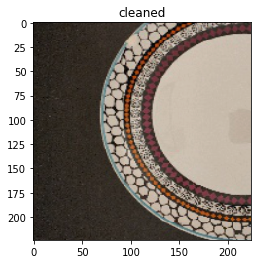

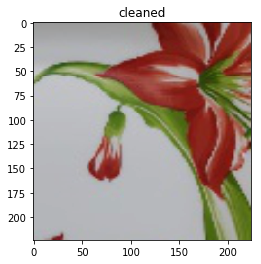

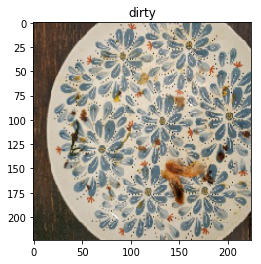

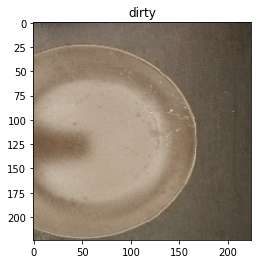

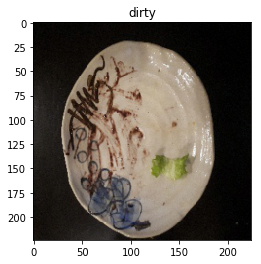

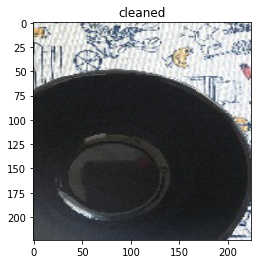

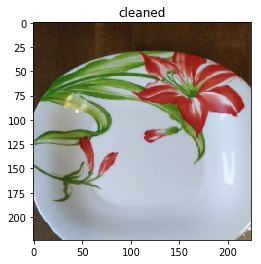

In [8]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [9]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [10]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [11]:
train_model(model, loss, optimizer, scheduler, num_epochs=100);

Epoch 0/99:


100%|██████████| 5/5 [00:00<00:00,  5.84it/s]

train Loss: 0.8401 Acc: 0.3000



100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

val Loss: 0.6803 Acc: 0.6667
Epoch 1/99:



100%|██████████| 5/5 [00:00<00:00,  6.63it/s]

train Loss: 0.7680 Acc: 0.4750



100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

val Loss: 0.6468 Acc: 0.6667
Epoch 2/99:



100%|██████████| 5/5 [00:00<00:00, 10.86it/s]

train Loss: 0.7603 Acc: 0.5750



100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

val Loss: 0.6979 Acc: 0.6667
Epoch 3/99:



100%|██████████| 5/5 [00:00<00:00, 11.05it/s]

train Loss: 0.6025 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

val Loss: 0.6508 Acc: 0.6667
Epoch 4/99:



100%|██████████| 5/5 [00:00<00:00, 10.99it/s]

train Loss: 0.5699 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

val Loss: 0.6545 Acc: 0.6667
Epoch 5/99:



100%|██████████| 5/5 [00:00<00:00, 10.69it/s]

train Loss: 0.5700 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

val Loss: 0.6305 Acc: 0.6667
Epoch 6/99:



100%|██████████| 5/5 [00:00<00:00, 10.91it/s]

train Loss: 0.5295 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

val Loss: 0.6290 Acc: 0.6667
Epoch 7/99:



100%|██████████| 5/5 [00:00<00:00, 10.29it/s]

train Loss: 0.5454 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  5.52it/s]

val Loss: 0.6584 Acc: 0.6667
Epoch 8/99:



100%|██████████| 5/5 [00:00<00:00, 10.88it/s]

train Loss: 0.5518 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

val Loss: 0.6837 Acc: 0.6667
Epoch 9/99:



100%|██████████| 5/5 [00:00<00:00, 10.92it/s]

train Loss: 0.5273 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  5.53it/s]

val Loss: 0.7014 Acc: 0.6667
Epoch 10/99:



100%|██████████| 5/5 [00:00<00:00, 10.99it/s]

train Loss: 0.5602 Acc: 0.7000



100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

val Loss: 0.6857 Acc: 0.6667
Epoch 11/99:



100%|██████████| 5/5 [00:00<00:00, 10.78it/s]

train Loss: 0.5304 Acc: 0.7250



100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

val Loss: 0.6816 Acc: 0.6667
Epoch 12/99:



100%|██████████| 5/5 [00:00<00:00,  9.45it/s]

train Loss: 0.6200 Acc: 0.6750



100%|██████████| 1/1 [00:00<00:00,  5.49it/s]

val Loss: 0.6507 Acc: 0.6667
Epoch 13/99:



100%|██████████| 5/5 [00:00<00:00,  9.00it/s]

train Loss: 0.5076 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

val Loss: 0.6572 Acc: 0.6667
Epoch 14/99:



100%|██████████| 5/5 [00:00<00:00,  9.94it/s]

train Loss: 0.5373 Acc: 0.7250



100%|██████████| 1/1 [00:00<00:00,  5.52it/s]

val Loss: 0.6659 Acc: 0.6667
Epoch 15/99:



100%|██████████| 5/5 [00:00<00:00, 10.34it/s]

train Loss: 0.5451 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.14it/s]

val Loss: 0.6437 Acc: 0.6667
Epoch 16/99:



100%|██████████| 5/5 [00:00<00:00, 10.89it/s]

train Loss: 0.5767 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

val Loss: 0.6338 Acc: 0.6667
Epoch 17/99:



100%|██████████| 5/5 [00:00<00:00, 10.91it/s]

train Loss: 0.5666 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

val Loss: 0.6318 Acc: 0.6667
Epoch 18/99:



100%|██████████| 5/5 [00:00<00:00, 10.85it/s]

train Loss: 0.5028 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

val Loss: 0.6419 Acc: 0.6667
Epoch 19/99:



100%|██████████| 5/5 [00:00<00:00,  5.60it/s]

train Loss: 0.5985 Acc: 0.7000



100%|██████████| 1/1 [00:00<00:00,  5.49it/s]

val Loss: 0.6137 Acc: 0.6667
Epoch 20/99:



100%|██████████| 5/5 [00:00<00:00, 10.77it/s]

train Loss: 0.5626 Acc: 0.7250



100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

val Loss: 0.6448 Acc: 0.6667
Epoch 21/99:



100%|██████████| 5/5 [00:00<00:00, 10.90it/s]

train Loss: 0.5608 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

val Loss: 0.6455 Acc: 0.6667
Epoch 22/99:



100%|██████████| 5/5 [00:00<00:00, 11.03it/s]

train Loss: 0.5033 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

val Loss: 0.6567 Acc: 0.6667
Epoch 23/99:



100%|██████████| 5/5 [00:00<00:00, 10.98it/s]

train Loss: 0.5029 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

val Loss: 0.6740 Acc: 0.6667
Epoch 24/99:



100%|██████████| 5/5 [00:00<00:00, 10.61it/s]

train Loss: 0.4155 Acc: 0.9250



100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

val Loss: 0.6863 Acc: 0.6667
Epoch 25/99:



100%|██████████| 5/5 [00:00<00:00, 10.92it/s]

train Loss: 0.5811 Acc: 0.6750



100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

val Loss: 0.6589 Acc: 0.6667
Epoch 26/99:



100%|██████████| 5/5 [00:00<00:00, 10.74it/s]

train Loss: 0.6403 Acc: 0.6500



100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

val Loss: 0.6897 Acc: 0.6667
Epoch 27/99:



100%|██████████| 5/5 [00:00<00:00,  8.17it/s]

train Loss: 0.5262 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

val Loss: 0.6296 Acc: 0.6667
Epoch 28/99:



100%|██████████| 5/5 [00:00<00:00, 10.72it/s]

train Loss: 0.5865 Acc: 0.6750



100%|██████████| 1/1 [00:00<00:00,  5.53it/s]

val Loss: 0.6387 Acc: 0.6667
Epoch 29/99:



100%|██████████| 5/5 [00:00<00:00, 10.84it/s]

train Loss: 0.4814 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

val Loss: 0.6615 Acc: 0.6667
Epoch 30/99:



100%|██████████| 5/5 [00:00<00:00, 10.83it/s]

train Loss: 0.5154 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

val Loss: 0.6544 Acc: 0.6667
Epoch 31/99:



100%|██████████| 5/5 [00:00<00:00, 10.66it/s]

train Loss: 0.4965 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.35it/s]

val Loss: 0.6737 Acc: 0.6667
Epoch 32/99:



100%|██████████| 5/5 [00:00<00:00, 10.81it/s]

train Loss: 0.5384 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

val Loss: 0.6508 Acc: 0.6667
Epoch 33/99:



100%|██████████| 5/5 [00:00<00:00, 10.91it/s]

train Loss: 0.5815 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

val Loss: 0.6638 Acc: 0.6667
Epoch 34/99:



100%|██████████| 5/5 [00:00<00:00, 10.68it/s]

train Loss: 0.5486 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

val Loss: 0.6793 Acc: 0.6667
Epoch 35/99:



100%|██████████| 5/5 [00:00<00:00,  5.54it/s]

train Loss: 0.5169 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

val Loss: 0.6823 Acc: 0.6667
Epoch 36/99:



100%|██████████| 5/5 [00:00<00:00, 10.67it/s]

train Loss: 0.5723 Acc: 0.7250



100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

val Loss: 0.6529 Acc: 0.6667
Epoch 37/99:



100%|██████████| 5/5 [00:00<00:00,  9.43it/s]

train Loss: 0.6228 Acc: 0.6500



100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

val Loss: 0.6381 Acc: 0.6667
Epoch 38/99:



100%|██████████| 5/5 [00:00<00:00, 10.66it/s]

train Loss: 0.6108 Acc: 0.5750



100%|██████████| 1/1 [00:00<00:00,  5.49it/s]

val Loss: 0.6618 Acc: 0.6667
Epoch 39/99:



100%|██████████| 5/5 [00:00<00:00, 10.81it/s]

train Loss: 0.5250 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  5.35it/s]

val Loss: 0.7043 Acc: 0.6667
Epoch 40/99:



100%|██████████| 5/5 [00:00<00:00,  9.58it/s]

train Loss: 0.6062 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 0.6855 Acc: 0.6667
Epoch 41/99:



100%|██████████| 5/5 [00:00<00:00,  5.38it/s]

train Loss: 0.5739 Acc: 0.7000



100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

val Loss: 0.6590 Acc: 0.6667
Epoch 42/99:



100%|██████████| 5/5 [00:00<00:00, 10.63it/s]

train Loss: 0.4866 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

val Loss: 0.6526 Acc: 0.6667
Epoch 43/99:



100%|██████████| 5/5 [00:00<00:00, 10.92it/s]

train Loss: 0.5751 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

val Loss: 0.6913 Acc: 0.6667
Epoch 44/99:



100%|██████████| 5/5 [00:00<00:00, 10.64it/s]

train Loss: 0.5068 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

val Loss: 0.6891 Acc: 0.6667
Epoch 45/99:



100%|██████████| 5/5 [00:00<00:00, 10.49it/s]

train Loss: 0.5878 Acc: 0.7250



100%|██████████| 1/1 [00:00<00:00,  5.35it/s]

val Loss: 0.6250 Acc: 0.6667
Epoch 46/99:



100%|██████████| 5/5 [00:00<00:00, 10.61it/s]

train Loss: 0.5525 Acc: 0.7250



100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

val Loss: 0.6281 Acc: 0.6667
Epoch 47/99:



100%|██████████| 5/5 [00:00<00:00, 10.76it/s]

train Loss: 0.5973 Acc: 0.6750



100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

val Loss: 0.6223 Acc: 0.6667
Epoch 48/99:



100%|██████████| 5/5 [00:00<00:00, 10.71it/s]

train Loss: 0.4761 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

val Loss: 0.6563 Acc: 0.6667
Epoch 49/99:



100%|██████████| 5/5 [00:00<00:00, 10.60it/s]

train Loss: 0.5484 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  5.35it/s]

val Loss: 0.6681 Acc: 0.6667
Epoch 50/99:



100%|██████████| 5/5 [00:00<00:00, 10.59it/s]

train Loss: 0.5297 Acc: 0.7250



100%|██████████| 1/1 [00:00<00:00,  5.22it/s]

val Loss: 0.6563 Acc: 0.6667
Epoch 51/99:



100%|██████████| 5/5 [00:00<00:00, 10.65it/s]

train Loss: 0.5288 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

val Loss: 0.6186 Acc: 0.6667
Epoch 52/99:



100%|██████████| 5/5 [00:00<00:00, 10.51it/s]

train Loss: 0.5462 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

val Loss: 0.6143 Acc: 0.6667
Epoch 53/99:



100%|██████████| 5/5 [00:00<00:00, 10.59it/s]

train Loss: 0.4811 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

val Loss: 0.6379 Acc: 0.6667
Epoch 54/99:



100%|██████████| 5/5 [00:00<00:00,  8.59it/s]

train Loss: 0.6209 Acc: 0.6750



100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

val Loss: 0.6496 Acc: 0.6667
Epoch 55/99:



100%|██████████| 5/5 [00:00<00:00, 10.32it/s]

train Loss: 0.5777 Acc: 0.6750



100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

val Loss: 0.6532 Acc: 0.6667
Epoch 56/99:



100%|██████████| 5/5 [00:00<00:00, 10.59it/s]

train Loss: 0.5147 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  4.91it/s]

val Loss: 0.6736 Acc: 0.6667
Epoch 57/99:



100%|██████████| 5/5 [00:00<00:00, 10.67it/s]

train Loss: 0.5427 Acc: 0.7000



100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

val Loss: 0.6715 Acc: 0.6667
Epoch 58/99:



100%|██████████| 5/5 [00:00<00:00, 10.71it/s]

train Loss: 0.5152 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

val Loss: 0.6427 Acc: 0.6667
Epoch 59/99:



100%|██████████| 5/5 [00:00<00:00, 10.65it/s]

train Loss: 0.5744 Acc: 0.6500



100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

val Loss: 0.6461 Acc: 0.6667
Epoch 60/99:



100%|██████████| 5/5 [00:00<00:00, 10.92it/s]

train Loss: 0.5381 Acc: 0.7250



100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

val Loss: 0.6450 Acc: 0.6667
Epoch 61/99:



100%|██████████| 5/5 [00:00<00:00,  9.46it/s]

train Loss: 0.5773 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

val Loss: 0.6251 Acc: 0.6667
Epoch 62/99:



100%|██████████| 5/5 [00:00<00:00, 10.85it/s]

train Loss: 0.5771 Acc: 0.7000



100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

val Loss: 0.6207 Acc: 0.6667
Epoch 63/99:



100%|██████████| 5/5 [00:00<00:00, 10.74it/s]

train Loss: 0.5472 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

val Loss: 0.6197 Acc: 0.6667
Epoch 64/99:



100%|██████████| 5/5 [00:00<00:00, 10.77it/s]

train Loss: 0.4947 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

val Loss: 0.6283 Acc: 0.6667
Epoch 65/99:



100%|██████████| 5/5 [00:00<00:00, 10.72it/s]

train Loss: 0.5368 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

val Loss: 0.6380 Acc: 0.6667
Epoch 66/99:



100%|██████████| 5/5 [00:00<00:00, 10.47it/s]

train Loss: 0.5899 Acc: 0.5500



100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

val Loss: 0.6175 Acc: 0.6667
Epoch 67/99:



100%|██████████| 5/5 [00:00<00:00,  9.39it/s]

train Loss: 0.6274 Acc: 0.6500



100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

val Loss: 0.6368 Acc: 0.6667
Epoch 68/99:



100%|██████████| 5/5 [00:00<00:00,  9.32it/s]

train Loss: 0.5622 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

val Loss: 0.6836 Acc: 0.6667
Epoch 69/99:



100%|██████████| 5/5 [00:00<00:00, 10.77it/s]

train Loss: 0.4555 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

val Loss: 0.6679 Acc: 0.6667
Epoch 70/99:



100%|██████████| 5/5 [00:00<00:00, 10.73it/s]

train Loss: 0.4436 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

val Loss: 0.6573 Acc: 0.6667
Epoch 71/99:



100%|██████████| 5/5 [00:00<00:00, 10.80it/s]

train Loss: 0.5754 Acc: 0.6000



100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

val Loss: 0.7043 Acc: 0.6667
Epoch 72/99:



100%|██████████| 5/5 [00:00<00:00, 10.76it/s]

train Loss: 0.6035 Acc: 0.5750



100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

val Loss: 0.7138 Acc: 0.6667
Epoch 73/99:



100%|██████████| 5/5 [00:00<00:00, 10.23it/s]

train Loss: 0.6009 Acc: 0.6750



100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

val Loss: 0.6654 Acc: 0.6667
Epoch 74/99:



100%|██████████| 5/5 [00:00<00:00, 10.72it/s]

train Loss: 0.4758 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

val Loss: 0.6884 Acc: 0.6667
Epoch 75/99:



100%|██████████| 5/5 [00:00<00:00, 10.71it/s]

train Loss: 0.4533 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

val Loss: 0.7058 Acc: 0.6667
Epoch 76/99:



100%|██████████| 5/5 [00:00<00:00, 10.73it/s]

train Loss: 0.5488 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  5.21it/s]

val Loss: 0.6870 Acc: 0.6667
Epoch 77/99:



100%|██████████| 5/5 [00:00<00:00, 10.77it/s]

train Loss: 0.5392 Acc: 0.7250



100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

val Loss: 0.6741 Acc: 0.6667
Epoch 78/99:



100%|██████████| 5/5 [00:00<00:00, 10.87it/s]

train Loss: 0.5941 Acc: 0.6500



100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

val Loss: 0.7082 Acc: 0.6667
Epoch 79/99:



100%|██████████| 5/5 [00:00<00:00,  9.84it/s]

train Loss: 0.5246 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

val Loss: 0.6902 Acc: 0.6667


Epoch 80/99:


100%|██████████| 5/5 [00:00<00:00,  6.41it/s]

train Loss: 0.5721 Acc: 0.6000



100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

val Loss: 0.7240 Acc: 0.6667
Epoch 81/99:



100%|██████████| 5/5 [00:00<00:00,  8.33it/s]

train Loss: 0.5185 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

val Loss: 0.7045 Acc: 0.6667
Epoch 82/99:



100%|██████████| 5/5 [00:00<00:00, 10.38it/s]

train Loss: 0.4615 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

val Loss: 0.7042 Acc: 0.6667
Epoch 83/99:



100%|██████████| 5/5 [00:00<00:00, 10.43it/s]

train Loss: 0.6221 Acc: 0.6750



100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

val Loss: 0.7130 Acc: 0.6667
Epoch 84/99:



100%|██████████| 5/5 [00:00<00:00, 10.42it/s]

train Loss: 0.5253 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  5.22it/s]

val Loss: 0.6824 Acc: 0.6667
Epoch 85/99:



100%|██████████| 5/5 [00:00<00:00,  9.05it/s]

train Loss: 0.6062 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  5.17it/s]

val Loss: 0.6875 Acc: 0.6667
Epoch 86/99:



100%|██████████| 5/5 [00:00<00:00, 10.57it/s]

train Loss: 0.5227 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

val Loss: 0.6844 Acc: 0.6667
Epoch 87/99:



100%|██████████| 5/5 [00:00<00:00, 10.35it/s]

train Loss: 0.5668 Acc: 0.7000



100%|██████████| 1/1 [00:00<00:00,  5.16it/s]

val Loss: 0.6734 Acc: 0.6667
Epoch 88/99:



100%|██████████| 5/5 [00:00<00:00, 10.55it/s]

train Loss: 0.5272 Acc: 0.7250



100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

val Loss: 0.6508 Acc: 0.6667
Epoch 89/99:



100%|██████████| 5/5 [00:00<00:00, 10.54it/s]

train Loss: 0.5532 Acc: 0.7250



100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

val Loss: 0.6337 Acc: 0.6667
Epoch 90/99:



100%|██████████| 5/5 [00:00<00:00, 10.36it/s]

train Loss: 0.6088 Acc: 0.7000



100%|██████████| 1/1 [00:00<00:00,  5.18it/s]

val Loss: 0.6673 Acc: 0.6667
Epoch 91/99:



100%|██████████| 5/5 [00:00<00:00, 10.65it/s]

train Loss: 0.5201 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

val Loss: 0.6578 Acc: 0.6667
Epoch 92/99:



100%|██████████| 5/5 [00:00<00:00, 10.68it/s]

train Loss: 0.6078 Acc: 0.7250



100%|██████████| 1/1 [00:00<00:00,  5.14it/s]

val Loss: 0.6268 Acc: 0.6667
Epoch 93/99:



100%|██████████| 5/5 [00:00<00:00, 10.73it/s]

train Loss: 0.5739 Acc: 0.6750



100%|██████████| 1/1 [00:00<00:00,  5.40it/s]

val Loss: 0.6374 Acc: 0.6667
Epoch 94/99:



100%|██████████| 5/5 [00:00<00:00,  8.70it/s]

train Loss: 0.5035 Acc: 0.9250



100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

val Loss: 0.6411 Acc: 0.6667
Epoch 95/99:



100%|██████████| 5/5 [00:00<00:00, 10.74it/s]

train Loss: 0.6138 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

val Loss: 0.6418 Acc: 0.6667
Epoch 96/99:



100%|██████████| 5/5 [00:00<00:00, 10.68it/s]

train Loss: 0.5062 Acc: 0.7750



100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

val Loss: 0.6461 Acc: 0.6667
Epoch 97/99:



100%|██████████| 5/5 [00:00<00:00, 10.27it/s]

train Loss: 0.5042 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

val Loss: 0.6536 Acc: 0.6667
Epoch 98/99:



100%|██████████| 5/5 [00:00<00:00, 10.72it/s]

train Loss: 0.5492 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  5.35it/s]

val Loss: 0.6154 Acc: 0.6667
Epoch 99/99:



100%|██████████| 5/5 [00:00<00:00, 10.86it/s]

train Loss: 0.5445 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

val Loss: 0.6305 Acc: 0.6667


In [12]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [13]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [14]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test

In [15]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:03<00:00, 26.69it/s]


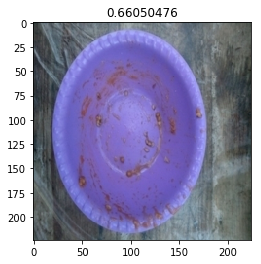

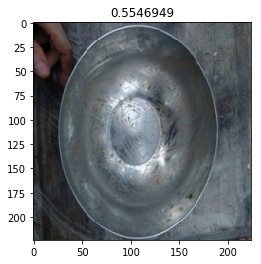

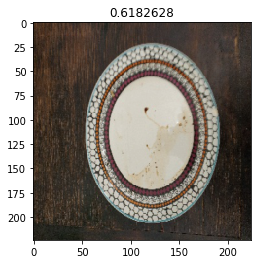

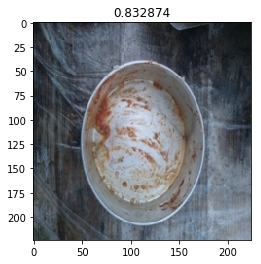

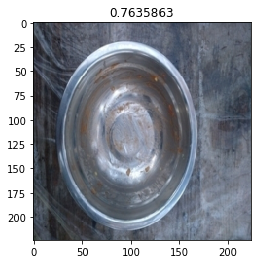

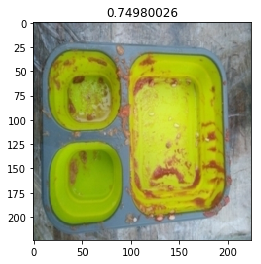

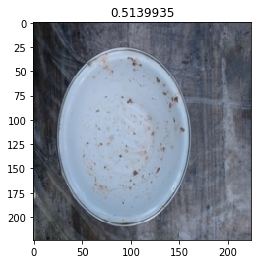

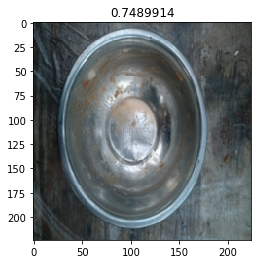

In [16]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [17]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [18]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty


In [19]:
submission_df.to_csv('submission.csv')

In [20]:
!rm -rf train val test